# Sentiment analysis on IMDB large movie review dataset

Get the dataset from [here](http://ai.stanford.edu/~amaas/data/sentiment/)

In [33]:
from glob import glob
import pandas as pd
import io
import numpy as np
import re
from IPython.display import SVG

from keras import models, layers
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Prepare dataset

In [53]:
def parse_text(text):
    text = text.strip()
    # remove html
    text = re.sub(string=text, pattern=r"<[^>]*>", repl="")
    # add spaces between special characters
    text = re.sub(string=text,
                  pattern=r"([$&+,:;=?@#|\"<>.^*()%!-])",
                  repl=r" \1 ")
    return text

def read_and_append_files(folder, label):
    texts = []
    for file in glob('./aclImdb/{0}/*.txt'.format(folder)):
        with open(file, 'r') as f:
            text = f.read()
            text = parse_text(text)
            texts.append((text, label))
            
    return texts

def make_df(pos, neg):
    df = pd.concat([pd.DataFrame(pos),
                    pd.DataFrame(neg)])\
           .sample(frac=1)\
           .reset_index(drop=True)
    df.columns = ['review', 'label']
    
    return df

In [54]:
train_pos = read_and_append_files('train/pos', 1)
train_neg = read_and_append_files('train/neg', 0)

test_pos = read_and_append_files('test/pos', 1)
test_neg = read_and_append_files('test/neg', 0)

In [55]:
train_df = make_df(train_pos, train_neg)
test_df = make_df(test_pos, test_neg)

In [56]:
train_df.head()

,review,label
0,Even with a cast that boasts such generally re...,0
1,This film is so bad and gets worse in every im...,0
2,A comedy of epically funny proportions from th...,1
3,"On the surface , "" Show Me The Money "" shou...",0
4,A fabulous film . With everything you could w...,1


In [57]:
test_df.head()

,review,label
0,An interesting companion piece to true documen...,1
1,While I can't say whether or not Larry Hama ev...,1
2,"I went to see this film out of curiosity , an...",1
3,This movie was so dumb and slow was it ever sl...,0
4,All the pro comments about this movie claim th...,0


In [58]:
train_df["review"].iloc[0]

"Even with a cast that boasts such generally reliable names as Val Kilmer and Lisa Kudrow ,  Wonderland fails to yield any sense of depth to this film .  It barely brushes the surface of the incidents that happened on that July night in 1981 .  Kilmer just goes through the motions as John Holmes and Kudrow and Kate Bosworth are both hopefully miscast in the other two lead roles ;  as Holmes's wife and underage girlfriend ,  respectively .  The rest of the cast has such small roles that it's impossible to get any dimensions from them .  The film also stars Carrie Fisher ,  Ted Levine ,  Franky G ,  MC Gainey ,  Dylan McDermott and a cameo from Paris Hilton . "

## Embeddings

I use [Fast Text pre trained embeddings](https://fasttext.cc/docs/en/english-vectors.html).

In [69]:
t = Tokenizer(lower=False, filters='\t\n')
t.fit_on_texts(train_df['review'])

In [60]:
def load_vectors(fname, word_index):
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    for line in fin:
        tokens = line.rstrip().split(' ')
        if tokens[0] in word_index:
            w = word_index[tokens[0]]
            embedding_matrix[w] = np.fromiter(map(float, tokens[1:]), 'float')
    
    return embedding_matrix

In [71]:
%time vectors = load_vectors('/Users/eric/Code/wiki-news-300d-1M.vec', t.word_index)

CPU times: user 37.7 s, sys: 2.22 s, total: 39.9 s
Wall time: 40.4 s


In [72]:
vectors.shape

(113252, 300)

## Machine Learning with Keras

In [14]:
x_train = t.texts_to_matrix(train_df['review'])
y_train = train_df['label']

x_test = t.texts_to_matrix(test_df['review'])
y_test = test_df['label']

In [15]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000, 88566), (25000,), (25000, 88566), (25000,))

### Logistic regression

In [18]:
i = layers.Input(shape=(x_train.shape[1],))
h = layers.Dense(units=1, activation='sigmoid')(i)
model = models.Model(inputs=[i], outputs=[h])

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['binary_accuracy'])

# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=5)

### Averaging Embeddings

In [75]:
x_train = pad_sequences(t.texts_to_sequences(train_df['review']), maxlen=1000)
y_train = train_df['label']

x_test = pad_sequences(t.texts_to_sequences(test_df['review']), maxlen=1000)
y_test = test_df['label']

In [76]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000, 1000), (25000,), (25000, 1000), (25000,))

In [ ]:
i = layers.Input(shape=(x_train.shape[1],))

embedding_layer = layers.Embedding(input_dim=vectors.shape[0],
                                   output_dim=vectors.shape[1],
                                   weights=[vectors],
                                   trainable=False)

h = embedding_layer(i)
h = layers.Lambda(lambda r: K.mean(r, axis=1))(h)
h = layers.Dense(128, activation='relu')(h)
h = layers.Dense(1, activation='sigmoid')(h)

model = models.Model(inputs=[i], outputs=[h])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=2)

### Embeddings and GRU

In [ ]:
i = layers.Input(shape=(x_train.shape[1],))

embedding_layer = layers.Embedding(input_dim=vectors.shape[0],
                                   output_dim=vectors.shape[1],
                                   weights=[vectors],
                                   trainable=False)

h = embedding_layer(i)
h = layers.GRU(128)(h)
h = layers.Dense(1, activation='sigmoid')(h)

model = models.Model(inputs=[i], outputs=[h])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=2)

### Embeddings and CNN

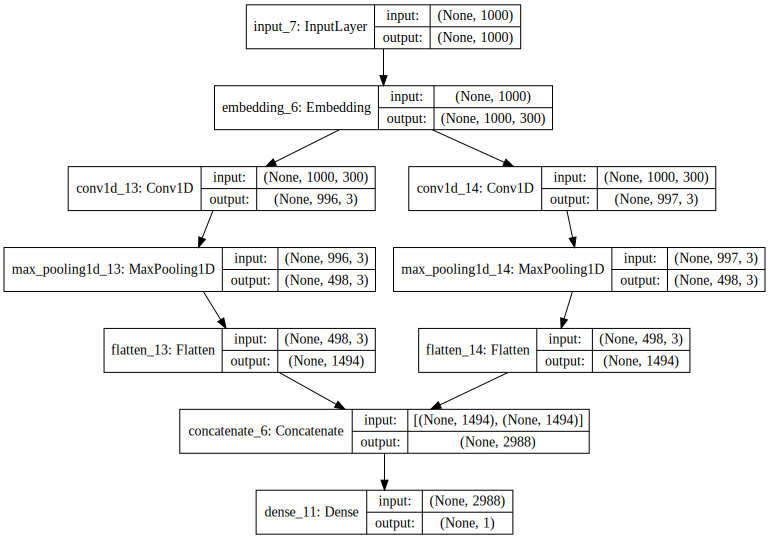

In [77]:
embedding_layer = layers.Embedding(input_dim=vectors.shape[0],
                                   output_dim=vectors.shape[1],
                                   weights=[vectors],
                                   trainable=False)

i = layers.Input(shape=(x_train.shape[1],))
text_embedding = embedding_layer(i)
convs = []

for layer_params in [(3, 5), (3, 4)]:
    conv = layers.Conv1D(filters=layer_params[0],
                         kernel_size=layer_params[1],
                         activation='relu')(text_embedding)
    conv = layers.MaxPooling1D(pool_size=2)(conv)
    conv = layers.Flatten()(conv)
    convs.append(conv)

concat = layers.concatenate(convs)
output = layers.Dense(1, activation='sigmoid')(concat)

model = models.Model(inputs=[i], outputs=[output])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [32]:
model.fit(x=x_train,
          y=y_train,
          validation_data=(x_test, y_test),
          epochs=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 212s 8ms/step - loss: 0.4829 - binary_accuracy: 0.7528 - val_loss: 0.3629 - val_binary_accuracy: 0.8452
Epoch 2/2
25000/25000 [==============================] - 212s 8ms/step - loss: 0.3286 - binary_accuracy: 0.8633 - val_loss: 0.3317 - val_binary_accuracy: 0.8531
